In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from augraphy import AugraphyPipeline, Letterpress, VoronoiTessellation, Hollow
from PIL import Image
from sklearn.model_selection import train_test_split
import uuid
from tqdm import tqdm

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
img_path = os.path.join('./data/train', '4fd4d1f693c164e6.jpg')
img_path = os.path.join('./data/train', 'df5de038a077c34a.jpg')
img_path = os.path.join('./data/train', 'ccda0529911b2f64.jpg')

# img_path = './aaaaa.jpg'
image = cv2.imread(img_path)

sum_image = cv2.imread('./data/train/373e02b8c92800b3.jpg')


In [3]:
transform_to_vertical_flip = A.VerticalFlip(p=0.5)

transform = A.Compose([
    A.GaussianBlur(blur_limit=(5,7), p=1.0),
    A.Rotate(limit=360, p=1.0,border_mode=0, value=(255,255,255)),
])
my_sequence = [
    VoronoiTessellation(
        num_cells_range=(2000,2000),
        mult_range=(50,80),
        noise_type="random",
        background_value=(30,40),
        numba_jit=1,
        p=0.7
    ),
]
pipeline  = AugraphyPipeline(my_sequence)

<class 'PIL.Image.Image'>


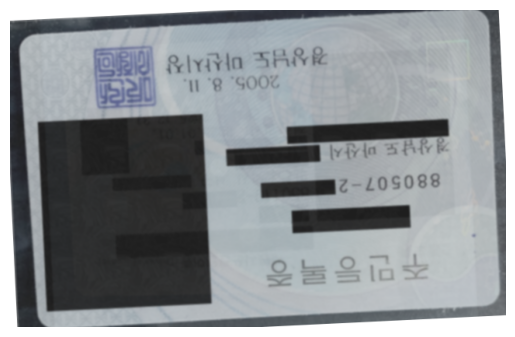

In [ ]:


# base 이미지 (배경)
base = Image.open("./data/train/59c8a51d54997fff.jpg").convert("RGBA")
print(type(base))
bw, bh = base.size
base = transform_to_vertical_flip(image=np.array(base))['image']
base = Image.fromarray(base)
# overlay 이미지 (덮을 이미지)

overlay = Image.open("./data/train/915151761e853562.jpg").convert("RGBA")
ow, oh = overlay.size
overlay = transform_to_vertical_flip(image=np.array(overlay))['image']
overlay = Image.fromarray(overlay)

# 1️⃣ overlay 이미지 비율 유지해서 축소
scale = min(bw / ow, bh / oh)
new_w = int(ow * scale)
new_h = int(oh * scale)
overlay_resized = overlay.resize((new_w, new_h), resample=Image.LANCZOS)

# 2️⃣ overlay 이미지 중앙 배치용 투명 캔버스
transparent_overlay = Image.new("RGBA", (bw, bh), (0, 0, 0, 0))

# 중앙 배치
x_offset = (bw - new_w) // 2
y_offset = (bh - new_h) // 2
transparent_overlay.paste(overlay_resized, (x_offset, y_offset))

# 3️⃣ 투명도 적용 (선택)
alpha = 20  # 0~255
transparent_overlay.putalpha(alpha)

# 4️⃣ 합성


result = Image.alpha_composite(base, transparent_overlay)

# 5️⃣ 화면 확인
# result.show()

# 6️⃣ 최종적으로 RGB(JPG 저장) 하고 싶으면
result_rgb = result.convert("RGB")
# result_rgb.show()

plt.imshow(transform(image=np.array(pipeline.augment(np.array(result_rgb))['output']))['image'])
# plt.imshow(pipeline.augment(np.array(result_rgb))['output'])
plt.axis("off")
plt.show()





In [4]:
df = pd.read_csv('./data/train.csv')

In [5]:
train_data, val_data = train_test_split(
    df,
    test_size=0.5,  # 5:5 비율로 설정
    random_state=42,
    # 열의 위치 대신 '이름'을 사용하여 stratify 지정 (더 안정적인 방법)
    stratify=df['target'] if 'target' in df.columns else None
)

In [7]:
# augmented

from pandas import DataFrame

alpha = 0.8
fit_count = 500
# path = './data/train_augmented2/'
# save_path = './data/train_augmented2.csv'
# data = train_data[:]

path = './data/val_augmented2/'
save_path = './data/val_augmented2.csv'
data = val_data[:]

pbar = tqdm(total=data['target'].unique().__len__()*fit_count)
os.makedirs(path, exist_ok=True)
data_augmented = []
for target,group in data.groupby('target'):
    count = 0
    while fit_count > count:
        for file_name in group['ID'].values:
            if count >= fit_count:
                continue
            base = Image.open('./data/train/'+file_name).convert("RGBA")

            bw, bh = base.size
            base = transform_to_vertical_flip(image=np.array(base))['image']
            base = Image.fromarray(base)

            if np.random.rand() < 0.2:
                random_file_name = np.random.choice(data['ID'].values)
                overlay = Image.open('./data/train/'+random_file_name).convert("RGBA")
                ow, oh = overlay.size
                overlay = transform_to_vertical_flip(image=np.array(overlay))['image']
                overlay = Image.fromarray(overlay)

                # 1️⃣ overlay 이미지 비율 유지해서 축소
                scale = min(bw / ow, bh / oh)
                new_w = int(ow * scale)
                new_h = int(oh * scale)
                overlay_resized = overlay.resize((new_w, new_h), resample=Image.LANCZOS)

                # 2️⃣ overlay 이미지 중앙 배치용 투명 캔버스
                transparent_overlay = Image.new("RGBA", (bw, bh), (0, 0, 0, 0))

                # 중앙 배치
                x_offset = (bw - new_w) // 2
                y_offset = (bh - new_h) // 2
                transparent_overlay.paste(overlay_resized, (x_offset, y_offset))

                # 3️⃣ 투명도 적용 (선택)
                alpha = 20  # 0~255
                transparent_overlay.putalpha(alpha)

                # 4️⃣ 합성
                base = Image.alpha_composite(base, transparent_overlay)
            base = base.convert("RGB")
            pbar.update(1)
            base = pipeline.augment(np.array(base))['output']
            augmented_image = transform(image=np.array(base))['image']
            augmented_file_name = f"{uuid.uuid4()}.jpg"
            Image.fromarray(augmented_image).save(f"{path}{augmented_file_name}")
            data_augmented.append({'ID':augmented_file_name,'target':target})
            count+=1
pd.DataFrame(data_augmented).sample(frac=1).reset_index(drop=True).to_csv(save_path,index=False)
pbar.close()

100%|██████████| 8500/8500 [55:34<00:00,  2.55it/s]  
